## ДАНО:
- Крупный интернет-магазин. 
- Подготовленный вместе с отделом маркетинка список гипотез для увеличения выручки.

## НЕОБХОДИМО:
- Приоретизировать гипотезы
- Запустить A/B тест
- Проанализировать результаты и принять решение об остановке или продолжении теста

## Вывод первой части. 
Топ 5 RICE и ICE одинаковые, только в разном порядке. На первом месте RICE гипотеза 7 т.к. её параметр reach выше остальных.Параметр reach показывает, скольких пользователей затронет изменение, которое мы хотим внести. Согласно гипотезе 7, все клиенты, попавшие на все основные страницы сайта встретятся с формой подписки, которую хотят добавить. 

Индикатор RICE в отличие от ICE учитывает помимо силы гипотезы, то скольких пользователей она затронет. Это более цельный показатель.

## Решение по тесту и вывод.

- Есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий. Выигрыш группы В по сравнению с группой А 15.8%
- Статистически значимого различия по среднему чеку между группам нет как по "сырым" так и по "очищенным" данным. Относительный прирост группы В в "сырых" данных 25%, в очищенных 2,4%, не являются статистически значимыми.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A.
- График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя

Останавливаем тест. Принимаем, что он прошёл успешно. Фиксируем победу группы В.

Необходимо иметь ввиду, что 58 пользователей попали в обе исследуемые группы. мы не стали их удалять т.к. в visitors у нас кумулятивные данные, мы их не сможем убрать. Можно убрать только в orders.  В идеале считать раздельно: с удаленными - средний чек, с не удаленными - конверсию.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as stats


### Часть.1 Приоритизация гипотез

#### Описание данных

Файл /datasets/hypothesis.csv
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [2]:
hypothesis = pd.read_csv ('/datasets/hypothesis.csv')
hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Увеличим ширину столбца, чтобы прочитать все гипотезы

In [3]:
pd.options.display.max_colwidth = 120
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


#### Предобработка данных первой части

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Изменим названия столбцов (оставим только нижний регистр), и тип int64 заменим на uint16

In [5]:
hypothesis.columns = [x.lower() for x in hypothesis.columns]
hypothesis[['reach', 'impact', 'confidence', 'efforts']] =(
  hypothesis[['reach', 'impact', 'confidence', 'efforts']].astype('uint16')
)
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      uint16
 2   impact      9 non-null      uint16
 3   confidence  9 non-null      uint16
 4   efforts     9 non-null      uint16
dtypes: object(1), uint16(4)
memory usage: 272.0+ bytes


#### Индикатор ICE (impact, confidence, effort )

In [7]:
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence'])/ hypothesis['efforts']).round()

ice = hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending = False)
ice

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


Выделим 5 наиболее перспективных гипотез.

In [8]:
ice.head()

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0


Топ 5 ICE: 8, 0, 7, 6, 2

#### Индикатор RICE (reach, impact, confidence, effort)

In [9]:
hypothesis['rice'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/ hypothesis['efforts']).round()

rice = hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending = False)
rice

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [10]:
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.0


In [11]:
rice.head()

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0


Топ 5 RICE:  7, 2, 0, 6, 8

#### Вывод первой части. 
Топ 5 RICE и ICE одинаковые, только в разном порядке. На первом месте RICE гипотеза 7 т.к. её параметр reach выше остальных.Параметр reach показывает, скольких пользователей затронет изменение, которое мы хотим внести. Согласно гипотезе 7, все клиенты, попавшие на все основные страницы сайта встретятся с формой подписки, которую хотят добавить. 

Индикатор RICE в отличие от ICE учитывает помимо силы гипотезы, то скольких пользователей она затронет. Это более цельный показатель.

### Часть 2. Анализ A/B-теста

#### Описание данных

Файл /datasets/orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [12]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [13]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


#### Предобработка данных второй части

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Приведём названия столбцов в orders к нижнему регистру. Столбцы date в обоих датафреймах приведём к формату datetime. Столбец revenue датафрейма orders приведём к типу uint32 вместо int64,  а столбец visitors в одноимённом датафрейме приведём к формату uint16.

In [16]:
orders.columns = [x.lower() for x in orders.columns]

In [17]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [18]:
orders['revenue'] = orders['revenue'].astype('uint32')
visitors['visitors'] = visitors['visitors'].astype('uint16')

Посмотрим есть ли пропуски и дубликаты.

In [19]:
orders.isna().sum()

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

In [20]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [21]:
orders.duplicated().sum()

0

In [22]:
visitors.duplicated().sum()

0

Проверим, нет ли пользователей, которые попали в обе тестируемые группы. 

In [23]:
orders.groupby('visitorid').agg({'group':'nunique'}).query('group > 1').count()

group    58
dtype: int64

58 пользователей попали в обе группы. Мы можем удалить этих пользователей из таблицы orders и уменьшить количество посещений в соответствующую дату в visitors. Пока будем просто иметь это ввиду дальше при анализе.

#### График кумулятивной выручки по группам

In [24]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups\
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group']) 

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам  названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


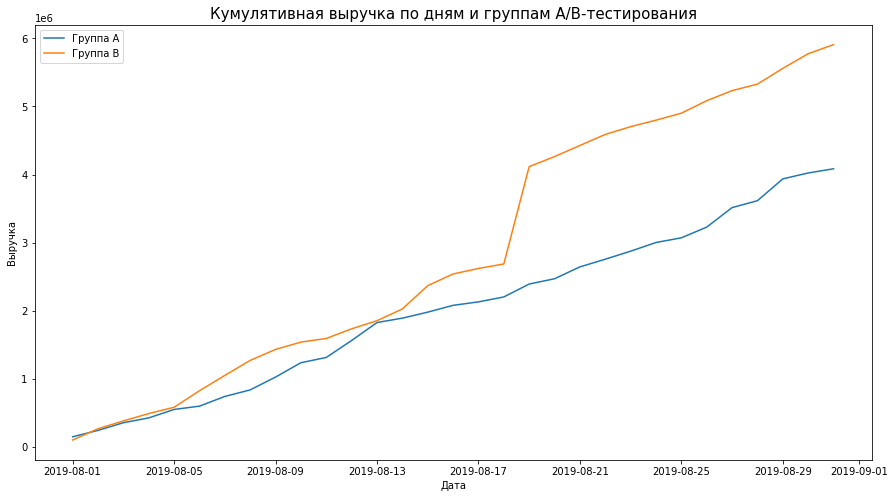

In [25]:
# Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования', fontsize=15)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Группа B')

plt.legend()
plt.show()

Группа B лидирует на протяжении всего теста, вначале был совсем небольшой разрыв, а в середине теста группа B гигантским скачком вырвалась вперёд, и эта разница сохранялась до конца всего теста. Этот резкий скачок может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

#### График кумулятивного среднего чека по группам

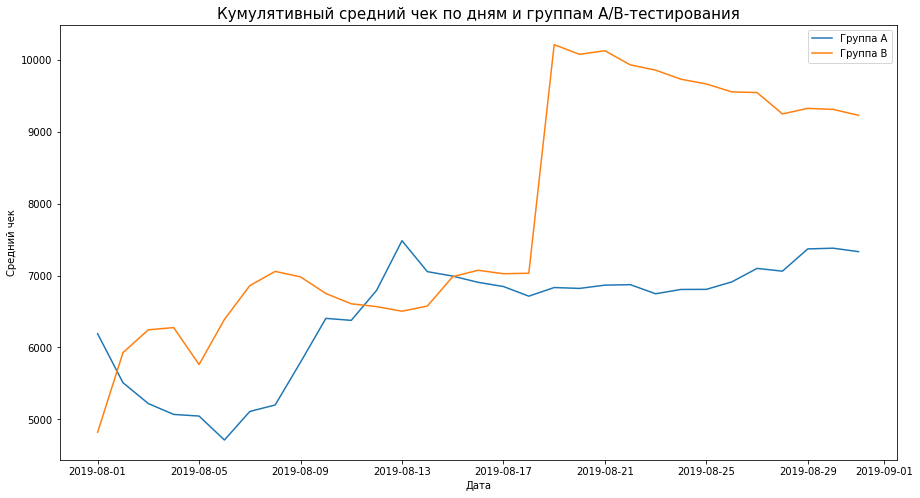

In [26]:
plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по дням и группам A/B-тестирования', fontsize=15)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')
plt.legend()
plt.show()

Куммулятивное значение среднего чека колеблется в обеих группах. У группы  А в первые дни теста наблюдаем уменьшение, потом наблюдаем стабильное увеличение чека, и с середины теста стабилизация вокруг 7000. Опять же наблюдаем характерный скачок у группы В в середине теста. Очень похоже на какой-то  не характерный аномальный заказ. Возможно если его исключить из данных, средние чеки сравняются по группам.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

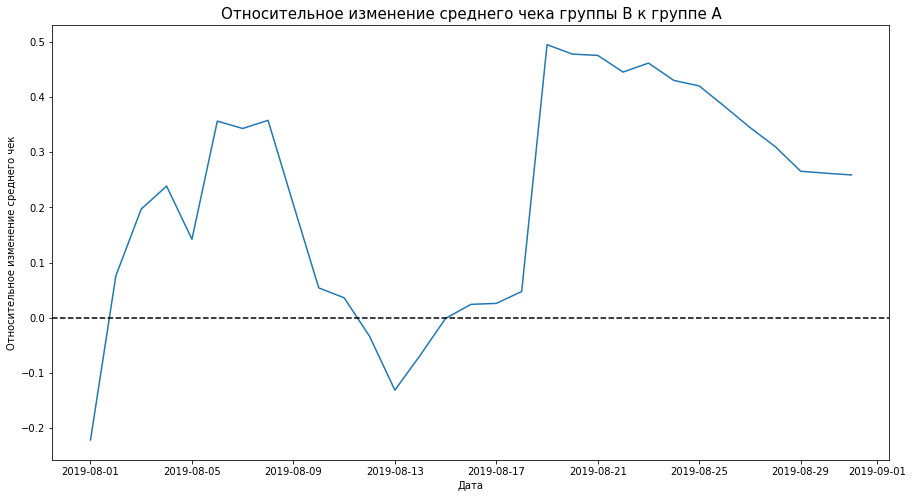

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.\
merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чек')
plt.title('Относительное изменение среднего чека группы B к группе А', fontsize=15)
plt.plot(mergedCumulativeRevenue['date'],\
(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(\
mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Результаты резко менялись несколько раз. Минимум на графике 13 августа совпадает с увеличением чека группы А, а скачок 17 августа с резким скачком чека группы B.

####  График кумулятивной конверсии по дням по группам

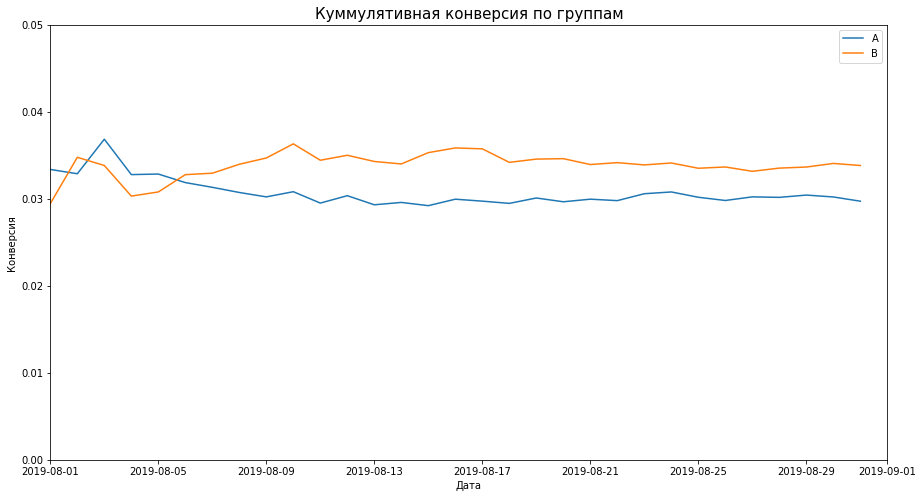

In [28]:
##### считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('Куммулятивная конверсия по группам', fontsize=15)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()


# задаем масштаб осей
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), 0, 0.05])
plt.show()

Вначале теста конверсии колебались, группа А имела большую конверсию, чем Группа В. Начиная с  6 августа ситуация поменялась на прямопротивоположную. Приблизительно с середины теста конверсии стабилизировались. Конверсия группы В больше конверсии группы А

#### График относительного различия кумулятивной конверсии группы B к группе A.

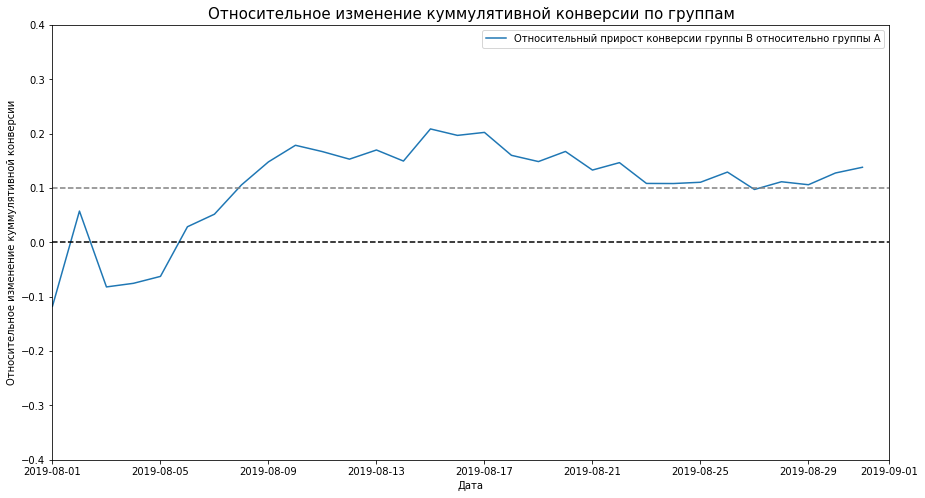

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Относительное изменение куммулятивной конверсии')
plt.title('Относительное изменение куммулятивной конверсии по группам', fontsize=15)
plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= 0.1, color='grey', linestyle='--')
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), -0.4, 0.4])
plt.show()

Практичсеки с самого начала теста группа В лидирует по конверсии. В середине теста прирост группы В достигает 20%, в итоге к концу теста фиксируется на 10%.

#### Точечный график количества заказов по пользователям

In [30]:
# Сначала подсчитаем количество заказов по пользователям и посмотрим на результат
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

ordersByUsers.columns = ['visitorid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

       visitorid  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов. Значительно больше, чем обычный пользователь за месяц.

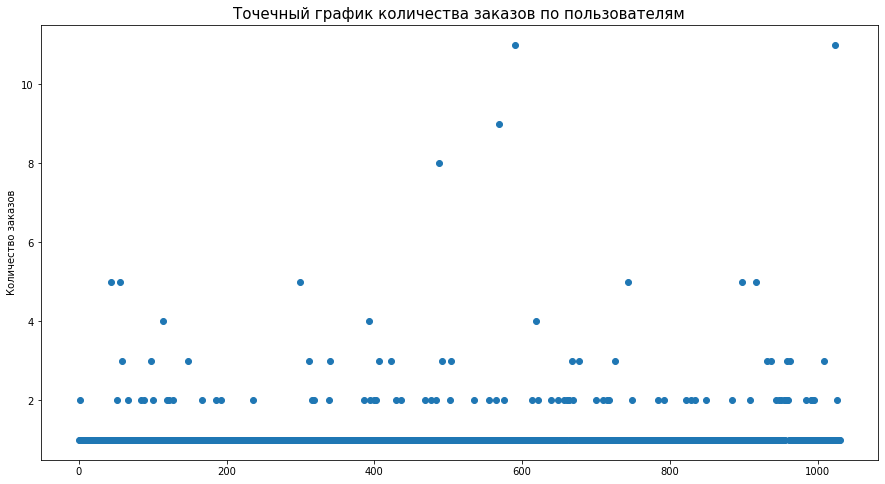

In [31]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15, 8))

plt.ylabel('Количество заказов')
plt.title('Точечный график количества заказов по пользователям', fontsize=15)

plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

Большинство пользователей с 1-3 заказами. Какова их доля, не известно. Посмотрим дальше.

#### 95-й и 99-й перцентили количества заказов на пользователя

In [32]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 1% пользователей оформляли больше чем 4  заказа. И 5% пользователей заказывали более двух раз.

Логично будет выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. Поскольку наши результаты содержать пользователей, которые были в обеих группах, то при их удалении, получившиеся перцентили будут другими.

#### Tочечный график стоимостей заказов

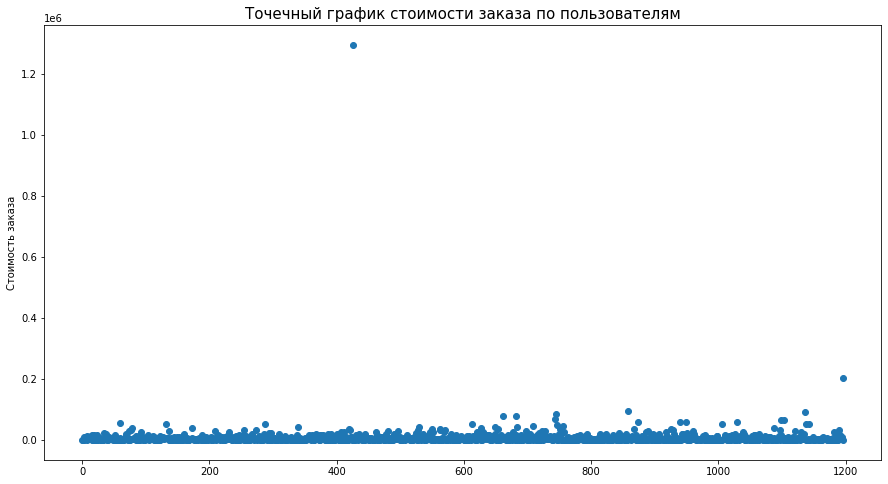

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15, 8))

plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимости заказа по пользователям', fontsize=15)

plt.scatter(x_values, orders['revenue']) 
plt.show()

Обычно стоимость заказа не превышает 100-150 тыс. Есть пара сильных выбросов - один в 200 тыс, а второй целых 1.2 млн. Возможно именно он дал резкий скачок на графиках группы В. 

#### 95-й и 99-й перцентили стоимости заказов

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более чем у 5% чек дороже 28000, и не более чем у 1 % чек дороже чем 58233. 50000 будет разумной границей отсечения аномальна дорогих заказов. Поскольку наши результаты содержать пользователей, которые были в обеих группах, то при их удалении, получившиеся перцентили будут другими. 

#### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

«сырые» данные — данные без удаления аномальных пользователей

Сформулируем гипотезы. 

- H0: различий в среднем количестве заказов между группами A и B нет.
- H1: различия в среднем между группами A и B есть.

In [35]:
#Подготовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Расшифровка названия столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

Критерий Манна-Уитни используется, когда в данных есть большие (по сравнению с нормальным распределением) выбросы, алгебраические метрики работают плохо. Это как раз наш случай.

In [37]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].\
sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].\
sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [38]:
print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('относительный прирост среднего числа заказов группы B',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
относительный прирост среднего числа заказов группы B 0.138


P-value < 0.05 - отвергаем нулевую гепотизу о том, что нет различий по заказам между группами. По "сырым" данным различия в среднем заказе есть. Выигрыш группы В по сравнению с группой А 13.8%

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным


Сформулируем гипотезы. 

- - H0: различий в среднем чеке между группами нет.
- - H1: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
Критерий Манна-Уитни используется, когда в данных есть большие (по сравнению с нормальным распределением) выбросы, алгебраические метрики работают плохо. Это как раз наш случай.

А ещё найдём относительные различия в среднем чеке между группами:

In [39]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
orders[orders['group']=='B']['revenue'])[1]))
print('относительный прирост среднего чека группы B','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].\
mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
относительный прирост среднего чека группы B 0.259


Наблюдаемое различие в 25%  не является статистически значимым. P-value значительно больше 0.05. Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. То что наблюдаемое различие довольно велико скорее всего связано с аномальными выбросами. Проверим это позже на "очищенных" данных.

#### Cтатистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным.

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 50 000 рублей.

Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 50 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers

In [40]:
orders_lim = np.percentile(ordersByUsers['orders'], 99)
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >orders_lim]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_lim]['userId'],
    ],
    axis=0,
)

revenue_lim = np.percentile(orders['revenue'], 99)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
dtype: int64
15


15 аномальных пользователей

Подготовим выборки количества заказов по пользователям по группам теста, чтобы посчитать статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным:

In [41]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительный прирост среднего числа заказов группы B',\
'{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.014
относительный прирост среднего числа заказов группы B 0.153


Результаты по среднему числу заказов практически не поменялись. По "очищенным" данным различия в среднем заказе есть. Выигрыш группы В по сравнению с группой А 15.3%

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [42]:
print(
    'p-value:', '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'относительный прирост среднего чека группы B', "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.851
относительный прирост среднего чека группы B -0.006


Средний чек группы B больше на 2,4 %  Это изменение не является статистически значимым. P-value: 0.819 > 0.05. Нулевая гипотеза, что различий между чеками нет, принимается.

По сравнению с "сырыми" данными наблюдаем значительное уменьшение относительного прироста.

#### Решение по тесту и вывод.

- Есть статистически значимое различие по среднему количеству заказов между группами как по сырым данным, так и после фильтрации аномалий. Выигрыш группы В по сравнению с группой А 15.8%
- Статистически значимого различия по среднему чеку между группам нет как по "сырым" так и по "очищенным" данным. Относительный прирост группы В в "сырых" данных 25%, в очищенных 2,4%, не являются статистически значимыми.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A.
- График различия среднего чека колеблется. Сделать из этого графика определённые выводы нельзя

Останавливаем тест. Принимаем, что он прошёл успешно. Фиксируем победу группы В.

Необходимо иметь ввиду, что 58 пользователей попали в обе исследуемые группы. мы не стали их удалять т.к. в visitors у нас кумулятивные данные, мы их не сможем убрать. Можно убрать только в orders.  В идеале считать раздельно: с удаленными - средний чек, с не удаленными - конверсию.

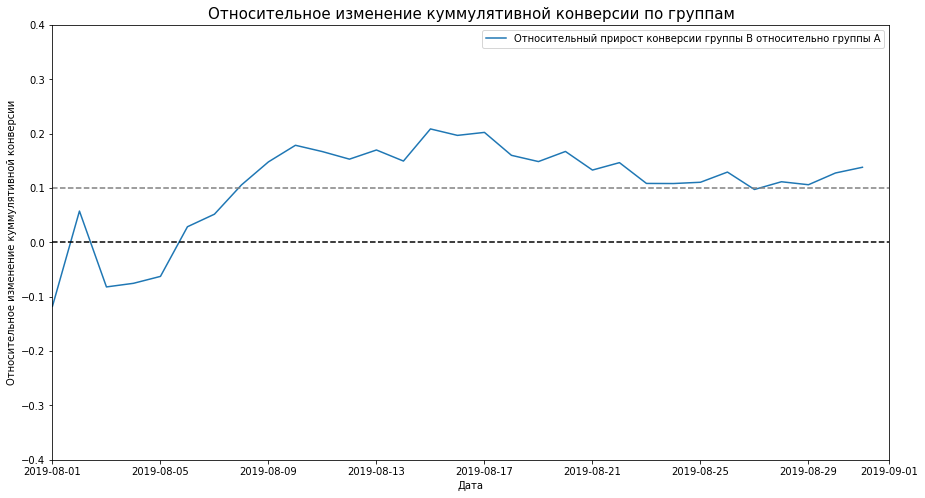

In [43]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].\
merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Относительное изменение куммулятивной конверсии')
plt.title('Относительное изменение куммулятивной конверсии по группам', fontsize=15)
plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y= 0.1, color='grey', linestyle='--')
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), -0.4, 0.4])
plt.show()